In [144]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc

In [145]:
knmi_data = pd.read_csv('data/knmi_data_weather.txt', skiprows=9, index_col=1, parse_dates=True, skipinitialspace=True)
rws_data = pd.read_csv('data/rws_data_discharge.csv', delimiter=';', parse_dates=[['WAARNEMINGDATUM', 'WAARNEMINGTIJD (MET/CET)']], index_col=0)

C:\Users\Jip\AppData\Local\Temp\ipykernel_14888\1211856417.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  rws_data = pd.read_csv('data/rws_data_discharge.csv', delimiter=';', parse_dates=[['WAARNEMINGDATUM', 'WAARNEMINGTIJD (MET/CET)']], index_col=0)


In [146]:
discharge = pd.DataFrame(rws_data['ALFANUMERIEKEWAARDE'])
discharge.index = pd.to_datetime(discharge.index, format='%d/%m/%Y %H:%M:%S')
precipitation = pd.DataFrame(knmi_data.loc['2010':]['RH'] / 10)
temperature = pd.DataFrame(knmi_data.loc['2010':]['TG'] / 10)
discharge = discharge.rename(columns={'ALFANUMERIEKEWAARDE': 'Discharge (m3/s)'})

In [188]:
discharge_W = discharge.resample('W').mean()
precipitation_W = precipitation.resample('W').sum()
temperature_W = temperature.resample('W').mean()
total_data = pd.concat([discharge_W, precipitation_W, temperature_W], axis=1).dropna()
total_data = total_data.rename(columns={'Discharge (m3/s)': 'Discharge', 'RH': 'Precipitation', 'TG': 'Temperature'})
keys = total_data.keys()

total_data.loc['2021']

,Discharge,Precipitation,Temperature
2021-01-03,931.522569,5.8,3.128571


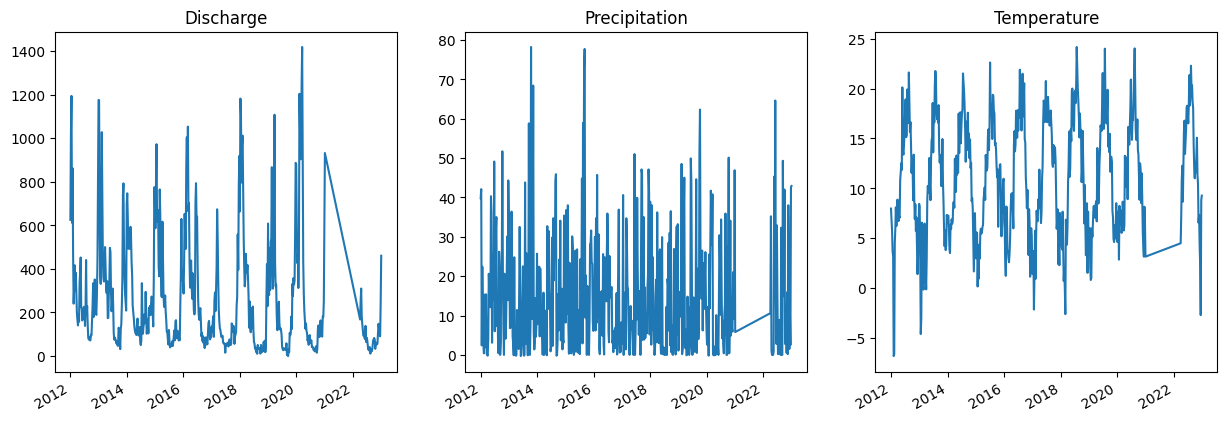

In [148]:
def plotter(data, keys):
    plt.figure(figsize=(15, 5))
    for i, key in enumerate(keys):
        ax = plt.subplot(1, 3, i + 1)
        data[key].plot(ax=ax)
        plt.title(f'{key}')
plotter(total_data, keys)



Discharge
self.slope=-1.615e+01, self.intercept=3.284e+04, self.rvalue=-1.841e-01, self.pvalue=2.835e-05, self.stderr=3.823e+00, self.intercept_stderr=7.711e+03
Precipitation
self.slope=-7.477e-02, self.intercept=1.657e+02, self.rvalue=-1.505e-02, self.pvalue=7.343e-01, self.stderr=2.201e-01, self.intercept_stderr=4.440e+02
Temperature
self.slope=2.682e-01, self.intercept=-5.299e+02, self.rvalue=1.375e-01, self.pvalue=1.835e-03, self.stderr=8.562e-02, self.intercept_stderr=1.727e+02


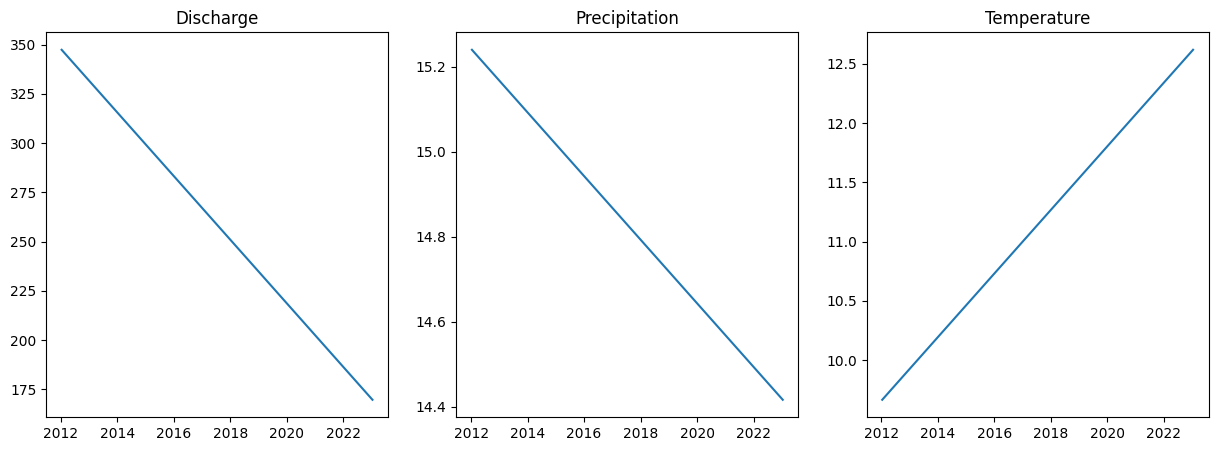

In [164]:
class linear_obj:
    def __init__(self, result, name, x):
        self.name = name
        self.slope = result.slope
        self.intercept = result.intercept
        self.rvalue = result.rvalue
        self.pvalue = result.pvalue
        self.stderr = result.stderr
        self.intercept_stderr = result.intercept_stderr
        self.x = x
        
    def print_values(self):
        print(self.name)
        print(f'{self.slope=:.3e}, {self.intercept=:.3e}, {self.rvalue=:.3e}, {self.pvalue=:.3e}, {self.stderr=:.3e}, {self.intercept_stderr=:.3e}')
  
    def linear_line(self, plot=False):
        self.y = self.intercept + self.slope * self.x      
        if plot:
            plt.title(self.name)
            plt.plot(self.x, self.y)
        
linearity = []

def linear(data, keys):  
    plt.figure(figsize=(15, 5))
    for i, key in enumerate(keys):
        x = data[key].index.values.astype(float) / (1e9 * 86400 * 365) + 1970
        y = data[key].values
        
        result = sc.stats.linregress(x, y)
        linearity.append(linear_obj(result, key, x))
        linearity[i].print_values()
        plt.subplot(1, 3, i + 1)
        linearity[i].linear_line(plot=True)
 
linear(total_data, keys)    


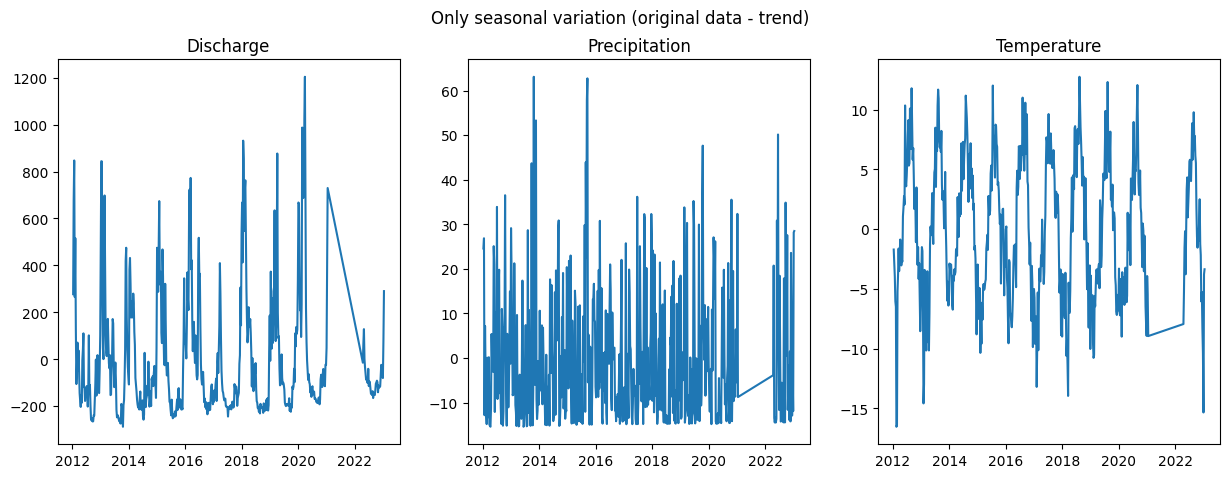

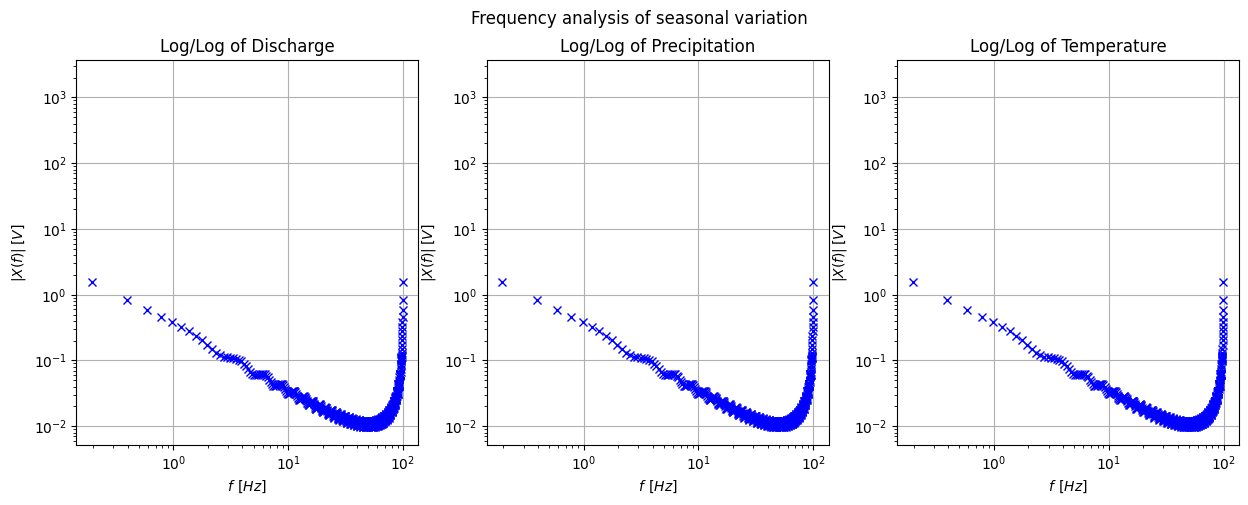

In [186]:
class seasonal_obj:
    def __init__(self, name, xy):
        self.name = name
        self.x, self.y = xy
        
    def plotter(self):
        plt.title(self.name)
        plt.plot(self.x, self.y)
    
seasonality = []
def seasonal(data, keys):
    plt.figure(figsize=(15, 5))
    plt.suptitle('Only seasonal variation (original data - trend)')
    for i, key in enumerate(keys):
        seasonality.append(seasonal_obj(key, (linearity[i].x, data[key] - linearity[i].y)))
        axes = plt.subplot(1, 3, i + 1)
        seasonality[i].plotter()
        
    # plt.figure(figsize=(15, 5))
    # plt.suptitle('Frequency analysis of seasonal variation')
    # for i, key in enumerate(keys):    
    #     axes = plt.subplot(1, 3, i + 1)
        
    #     fs = 100
    #     N = len(seasonality[i].x)        
    #     x_disc = np.abs(np.fft.fft(seasonality[i].x)) / N
    #     f_vec = np.arange(0, fs, fs / N)
        
    #     axes.plot(f_vec, x_disc, 'x', color='b', label='Fourier transform')
    #     axes.loglog()
    #     axes.set_xlabel('$f \: \: [Hz]$')
    #     axes.set_ylabel('$|X(f)| \: [V]$')
    #     axes.grid()
    #     axes.set_title(f'Log/Log of {seasonality[i].name}')
        
seasonal(total_data, keys)